# Get wallets that paid full royalties on Illuminati NFT sales

- Proof of Concept that it's possible to track full royalty payers for potential rewards.
- This can be expanded and generalized for other collections and uses.
- Only counts sales after OpenSea made royalties optional (uses old illuminati contract).
- Also adds who still holds (uses new illuminati contract).
- Data is from [Reservoir](https://reservoir.tools).

In [1]:
import requests
import os
import logging
import sys
import datetime

import pandas as pd
import numpy as np

from dotenv import load_dotenv, find_dotenv

In [2]:
# Configure logging output for Jupyter notebook cells.
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
# Finds .env and loads entries as environment variables.
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

#### Collection Sales and Royalty Info

In [159]:
def fetch_sales_for_a_contract_from_reservoir(contract: str, start_timestamp: float = None, 
                                              max_runs: int = 10) -> pd.DataFrame:
    ''' Fetches all sales for a contract from resorvoir, including royalty info.
    
    This endpoint limits results so it continues until it gets all or reaches max runs.
    '''
    url = 'https://api.reservoir.tools/sales/v5'

    headers = {
        'accept': '*/*',
        'x-api-key': os.environ.get('RESERVOIR_API_KEY')
    }

    params = {
        'contract' : contract,
        'limit' : 1000 # This endpoint's max results.
    }
    
    if start_timestamp is not None:
        params['startTimestamp'] = start_timestamp
    
    responses = []
    
    response = requests.get(url, headers=headers, params=params).json()
    response_df = pd.DataFrame(response['sales'])
    responses.append(response_df)

    logging.info(f'Completed first run for {contract}')
    
    # This endpoint limits results returned. If there are more, it iterates through 
    # all continuation tokens are handled or until the max number of runs. 
    run_counter = 0
    while True:
        if response['continuation'] is None:
            break
        params['continuation'] = response['continuation']
        response = requests.get(url, headers=headers, params=params).json()
        response_df = pd.DataFrame(response['sales'])
        responses.append(response_df)
        run_counter += 1
        logger.info(f'Completed continuation run #{run_counter}')
        if run_counter >= max_runs:
            logger.warning(f'Maximum number of runs ({max_runs}) reached')
            break

    df = pd.concat(responses)
    
    df['block_time'] = pd.to_datetime(df.timestamp, unit='s')
    
    # Summarize fetched sales data.
    n_sales = len(df)
    first_sale_date = df.block_time.min()
    last_sale_date = df.block_time.max()

    logging.info(f'Fetched a total of {n_sales} sales')
    logging.info(f'These sales took place from {first_sale_date} to {last_sale_date}')
    
    return df


def summarize_seller_royalty_behavior_by_wallet(sales):
    '''Aggretales sales stats and transaction hashes by royalty status for each wallet's selling.
    
    Only tracks seller's royalties since sellers set royalties on large markets.
    '''
    sales.paidFullRoyalty.fillna(False, inplace=True)
    
    # Add two columns for txn hashes based on royalty status (full or not).
    # Use these in aggregation to document txns by their royalty status for manual QA later. 
    # To-do: clean up txn hash storing code.
    sales['fullRoyaltyTxHash'] = ""
    sales['missingRoyaltyTxHash'] = ""
    sales.loc[sales.paidFullRoyalty, 'fullRoyaltyTxHash'] = sales.loc[sales.paidFullRoyalty, 'txHash']
    sales.loc[~sales.paidFullRoyalty, 'missingRoyaltyTxHash'] = sales.loc[~sales.paidFullRoyalty, 'txHash']
    
    
    royalty_summary = (sales.groupby('from').agg(
        full_royalty_rate = ('paidFullRoyalty',np.mean),
        full_royalty_sales = ('paidFullRoyalty',np.sum),
        total_sales = ('paidFullRoyalty',len),
        full_royalty_txns=('fullRoyaltyTxHash', lambda x: ', '.join(filter(None, x))),
        missing_royalty_txns=('missingRoyaltyTxHash', lambda x: ', '.join(filter(None, x)))
        )
    )
    # Dedupes transaction hashes. Fairly slow and inelegant, but works.
    royalty_summary.full_royalty_txns = (royalty_summary.full_royalty_txns
                                         .str.split(', ')
                                         .map(set)
                                         .map(lambda x: ', '.join(x))
        )
    royalty_summary.missing_royalty_txns = (royalty_summary.missing_royalty_txns
                                            .str.split(', ')
                                            .map(set)
                                            .map(lambda x: ', '.join(x))
        )
    royalty_summary['non_full_royalty_sales'] = royalty_summary['total_sales'] - royalty_summary['full_royalty_sales']
    royalty_summary = royalty_summary.reset_index().rename(columns={'from':'address'})
    
    n_wallets = len(royalty_summary)
    logging.info(f'Summarized seller royalty behavior for {n_wallets} wallets')
    
    royalty_summary = royalty_summary.sort_values(['full_royalty_rate','full_royalty_sales'], ascending=False)

    return royalty_summary

#### Holders and Output 

In [157]:
def fetch_current_holders_for_a_contract_from_reservoir(contract : str,
                                                        max_runs: int = 10) -> pd.DataFrame:
    ''' Fetches wallets currently holding NFTs of given contract from resevoir.  
    
    This endpoint limits results so it continues until it gets all or reaches max runs.
    '''
    url = "https://api.reservoir.tools/owners/v2"
    # This endpoint's max.
    limit = 500

    headers = {
        'accept': '*/*',
        'x-api-key': os.environ.get('RESERVOIR_API_KEY')
    }

    params = {
        'contract' : contract,
        'limit' :  limit 
    }
    
    responses = []
    
    response = requests.get(url, headers=headers, params=params).json()
    response_df = pd.DataFrame(response['owners'])
    responses.append(response_df)

    logging.info(f'Completed first run for {contract} holders')
    
    
    # This endpoint limits results returned. If there are more (i.e. past request returned full limit), 
    # it iterates until it gets all or to the max number of runs. 
    run_counter = 0
    while True:
        # If returned results are below API's limit, we got everything.
        if len(response_df) < limit:
            break
        params['offset'] = run_counter * limit + len(response_df)
        logging.debug(params['offset'])
        response = requests.get(url, headers=headers, params=params).json()
        response_df = pd.DataFrame(response['owners'])
        responses.append(response_df)
        run_counter += 1
        logger.info(f'Completed continuation run #{run_counter}')
        if run_counter >= max_runs:
            logger.warning(f'Maximum number of runs ({max_runs}) reached')
            break
    
    df = pd.concat(responses)
    
    # Adds today's date as a snapshot date for holdings.
    df['snapshot_date'] = datetime.date.today()
    
    n_holders = len(df)
    logging.info(f'Fetched a total of {n_holders} holders')
    
    return df


def clean_holders_data(holders):
    '''Cleans holder data by extracting tokens held from a JSON column and removes unneeded columns.'''
    
    holders['tokens'] = holders['ownership'].map(lambda x: x['tokenCount']).astype(float)
    
    logging.info(f'Cleaned holder data')
    
    return holders[['address','tokens','snapshot_date']]


def add_holder_data_to_royalty_summary(royalty_summary, holders):
    ''' Adds holder info from snapshot to royalty summary.'''
    
    royalty_summary = royalty_summary.merge(
        holders,
        how='left',
        on='address'
    )

    # Cleans royalty summary for non-holders by filling nulls.
    
    # Sellers with no holdings at snapshot have 0.
    royalty_summary.tokens = royalty_summary.tokens.fillna(0)
    
    # Extract snapshot date to fill for nulls.
    snapshot_date = royalty_summary.snapshot_date.dropna().iloc[0]
    royalty_summary.snapshot_date = royalty_summary.snapshot_date.fillna(snapshot_date)
    
    # Add a binary category for holdership.
    royalty_summary['holder_status'] = np.where(royalty_summary.tokens > 0, 'Holder', 'Non-Holder')
    
    logging.info(f'Added holder data to royalty summary')
    
    return royalty_summary


def clean_and_save_output(royalty_summary):
    '''Filters data for output and stores locally as a CSV.'''
    n_wallets = len(royalty_summary)
    logging.info(f'There are {n_wallets} wallets that sold an NFT')
    
    # Output is limited to wallets with at least one full royalty sale.
    output = royalty_summary[royalty_summary.full_royalty_sales >= 1]
    
    n_royalty_payers = len(output)
    percent_royalty_payers = round((n_royalty_payers / n_wallets) * 100, 1)
    
    logging.info(f'Only {n_royalty_payers} wallets paid full royalties on 1+ sales')
    logging.info(f'{percent_royalty_payers}% of wallets paid full royalties on 1+ sales')
    logging.info('Output is for wallets with 1+ full royalty sales')
    
    output_col_names = {
        'address' : 'Wallet',
        'full_royalty_rate' : 'Percent of Sales for Full Royalties',
        'full_royalty_sales' : 'Full Royalty Sales',
        'non_full_royalty_sales' : 'Non-Full Royalty Sales',
        'total_sales' : 'Total Sales',
        'tokens' : 'Illuminati Tokens Held on Snapshot Date',
        'snapshot_date' : 'Snapshot Date',
        'full_royalty_txns' : 'Tx Hashes for Full Royalties',
        'missing_royalty_txns' : 'Tx Hashes for Non-Full Royalties'

    }
    output_cols = ['Wallet','Percent of Sales for Full Royalties', 'Full Royalty Sales',
                  'Non-Full Royalty Sales','Total Sales','Illuminati Tokens Held on Snapshot Date',
                  'Snapshot Date', 'Tx Hashes for Full Royalties','Tx Hashes for Non-Full Royalties']

    output = output.rename(columns=output_col_names)[output_cols]
    
    logging.info(f'Prepared royalty summary for output')
    
    today_str = datetime.date.today()
    output_str = f'data/illuminati_royalty_payers_{today_str}.csv'
    output.to_csv(output_str, index=False)
    logging.info(f'Saved csv with output data locally at {output_str}')
    
    return output

In [7]:
# Use old contract (when royalties were optional) for sales.
# Use new contract to see who still holds illuminati assets.
contract_old = '0x26BAdF693F2b103B021c670c852262b379bBBE8A' # Old Illuminati contract
contract_new = '0x8CB05890B7A640341069fB65DD4e070367f4D2E6' # New Illuminati contract

# OpenSea made royalties optional on Feb 17, 2023.
start_date = '2023-02-18'
start_timestamp = datetime.datetime.strptime(start_date, "%Y-%m-%d").timestamp()

max_runs = 10

In [8]:
sales = fetch_sales_for_a_contract_from_reservoir(contract=contract_old, start_timestamp=start_timestamp, 
                                                  max_runs=max_runs)
sales.info()

2023-05-04 16:00:51,946 - root - INFO - Completed first run for 0x26BAdF693F2b103B021c670c852262b379bBBE8A
2023-05-04 16:00:51,951 - root - INFO - Fetched a total of 629 sales
2023-05-04 16:00:51,951 - root - INFO - These sales took place from 2023-02-18 05:16:47 to 2023-04-16 14:52:47
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 629 non-null    object        
 1   saleId             629 non-null    object        
 2   token              629 non-null    object        
 3   orderId            629 non-null    object        
 4   orderSource        629 non-null    object        
 5   orderSide          629 non-null    object        
 6   orderKind          629 non-null    object        
 7   from               629 non-null    object        
 8   to                 629 non-null    object        
 9 

In [9]:
sales.head()

,id,saleId,token,orderId,orderSource,orderSide,orderKind,from,to,amount,...,price,washTradingScore,royaltyFeeBps,paidFullRoyalty,feeBreakdown,isDeleted,createdAt,updatedAt,marketplaceFeeBps,block_time
0,299c30a35eb9c1f4e6388bf9828d27d31861929ac33f7e...,09fdf3591cd7af8eb33972fa9d4237238c199399a3e3c0...,{'contract': '0x26badf693f2b103b021c670c852262...,0x1b8aa15ba9b05d8071c92e191c35e48fee7c0e4e43a6...,gem.xyz,bid,seaport-v1.4,0x2acf5053b707a4fc7d568f98fe8161aaa4e74cc3,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:53:03.388Z,2023-04-16T14:54:21.392Z,NaN,2023-04-16 14:52:47
1,91dd14bf5beef3a6489f1b5a2e40cc26430e09ba6c9b08...,ad6fed82413400a667a10cc655b4a46b3a88a4762e1063...,{'contract': '0x26badf693f2b103b021c670c852262...,0xe538c16e143ebb2d11ba2b2b2e0739ec501821da5acd...,gem.xyz,bid,seaport-v1.4,0x15fca867b0521995dba0525cb3ec8e281b9a5807,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:10:28.645Z,2023-04-16T14:11:29.852Z,NaN,2023-04-16 14:10:23
2,07c00b4d54b587a26b60123c375ff072d1691210d022ae...,ca9d7a8816e16caee511491e1c1055942dda2ced1da495...,{'contract': '0x26badf693f2b103b021c670c852262...,0x6519474fca850f5bbb3c83f80bba186de0ea8beac76c...,looksrare.org,bid,looks-rare-v2,0xb055da94fd9ae45fe518da738d5c8da92ab1138f,0xedbe6ed3426e6c12bf1d1cd4ba06cc620d0800f1,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-16T13:31:51.479Z,2023-04-16T13:33:05.107Z,NaN,2023-04-16 13:31:47
3,3234b3821b2b408891a88bd0d7e3110559cac80159b496...,3ecf8eb299bde9097a1aa516aaf8023bbb302f6aeca4d1...,{'contract': '0x26badf693f2b103b021c670c852262...,0xd100fa8d62cd497a8c0904477a7cd3c44072035e8230...,blur.io,bid,blur,0x58454e733bf7d5999607c0e777a9a4df00d60d82,0x1c8f86d7647a9510fc715612c440a6c010c25b82,1,...,{'currency': {'contract': '0x00000000000000000...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T14:05:48.646Z,2023-04-13T14:06:43.769Z,NaN,2023-04-13 14:05:35
4,ba0742d5610d250675531f961cb60c0dcecc873b143fac...,1638de1b5eb631d5f00069f086a801992215bff7eb9604...,{'contract': '0x26badf693f2b103b021c670c852262...,0x06b9f04f1b0a851095c151ece9e48bb211476802482c...,opensea.io,ask,seaport-v1.4,0xeaeaa1e30d62bea880d5f38171bb32a2f91bfdce,0x53ed9466627eae9abe3b4cb1bcbc309cbe0e967b,1,...,{'currency': {'contract': '0x00000000000000000...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T13:00:30.279Z,2023-04-13T13:01:28.920Z,NaN,2023-04-13 13:00:11


In [160]:
royalty_summary = summarize_seller_royalty_behavior_by_wallet(sales)
royalty_summary.head()

2023-05-04 18:51:57,829 - root - INFO - Summarized seller royalty behavior for 326 wallets


,address,full_royalty_rate,full_royalty_sales,total_sales,full_royalty_txns,missing_royalty_txns,non_full_royalty_sales
244,0xbdaefe578294842fb433769c6b0d95130099e96e,1.0,10,10,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,,0
110,0x53508d1e1bc0e002bde092364bd9a4c6290b2c1e,1.0,4,4,0xd683cf54221da3cdf3c3b52627642bf2e62c260475e2...,,0
289,0xe0e76a34c17635ebff5d80b1e387fcdd4eeab863,1.0,4,4,0x5114203f8396d47f589d8de6feff790dd2210a378373...,,0
49,0x286cd03339811af0733d380a115cae81ba0be294,1.0,3,3,0x93b50462969810b372ac854a9e0418b41868fbf2c90e...,,0
225,0xaf765c32e6024f29111ee5a4ad193b8b3c46971b,1.0,3,3,0xd650ab8142be2d68b3aa31815231572ad8c6482a59db...,,0


In [11]:
holders = fetch_current_holders_for_a_contract_from_reservoir(contract=contract_old, 
                                                              max_runs=max_runs)
holders = clean_holders_data(holders)
holders.info()

2023-05-04 16:00:55,561 - root - INFO - Completed first run for 0x26BAdF693F2b103B021c670c852262b379bBBE8A holders
2023-05-04 16:00:56,285 - root - INFO - Completed continuation run #1
2023-05-04 16:00:57,202 - root - INFO - Completed continuation run #2
2023-05-04 16:00:58,468 - root - INFO - Completed continuation run #3
2023-05-04 16:00:59,386 - root - INFO - Completed continuation run #4
2023-05-04 16:01:00,279 - root - INFO - Completed continuation run #5
2023-05-04 16:01:01,055 - root - INFO - Completed continuation run #6
2023-05-04 16:01:01,666 - root - INFO - Completed continuation run #7
2023-05-04 16:01:01,674 - root - INFO - Fetched a total of 3525 holders
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 0 to 24
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   address        3525 non-null   object
 1   ownership      3525 non-null   object
 2   snapshot_date  3525 non-null   object
dtyp

In [161]:
royalty_summary = add_holder_data_to_royalty_summary(royalty_summary, holders)

2023-05-04 18:52:23,825 - root - INFO - Added holder data to royalty summary


In [162]:
output = clean_and_save_output(royalty_summary)


2023-05-04 18:52:25,394 - root - INFO - There are 326 wallets that sold an NFT
2023-05-04 18:52:25,399 - root - INFO - Only 99 wallets paid full royalties on 1+ sales
2023-05-04 18:52:25,400 - root - INFO - 30.4% of wallets paid full royalties on 1+ sales
2023-05-04 18:52:25,401 - root - INFO - Output is for wallets with 1+ full royalty sales
2023-05-04 18:52:25,405 - root - INFO - Prepared royalty summary for output
2023-05-04 18:52:25,412 - root - INFO - Saved csv with output data locally at data/illuminati_royalty_payers_2023-05-04.csv


# Analysis

* Only 99 of 326 wallets (30%) paid full royalties at least once when selling (during this time)
* Of those 99 wallets, 83% paid full royalties on all illuminati sales (i.e. 17% didn't pay sometimes)
* Of those 99 wallets, only 31% still hold an illuminati (new contract), which makes sense given these were sellers

In [145]:
royalty_summary.columns

Index(['address', 'full_royalty_rate', 'full_royalty_sales', 'total_sales',
       'full_royalty_txns', 'missing_royalty_txns', 'non_full_royalty_sales',
       'tokens', 'snapshot_date', 'Holder Status', 'holder_status'],
      dtype='object')

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [150]:
sales.loc[~sales.paidFullRoyalty,'royaltyFeeBps'].value_counts().sort_index()

1.0         1
24.0        8
25.0        2
42.0       12
49.0        1
50.0      365
99.0       19
100.0      19
115.0       3
116.0       3
140.0       5
164.0       4
169.0       1
190.0      16
198.0       2
249.0       2
250.0       2
271.0       2
277.0       3
333.0       1
350.0       1
393.0       1
1428.0      1
Name: royaltyFeeBps, dtype: int64

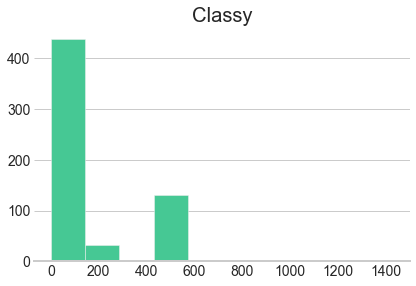

In [106]:
plt.style.use('fivethirtyeight')
plt.rcParams["axes.grid.axis"] ="y"

plt.rcParams["axes.edgecolor"] = '#cbcbcb'#'.15'
plt.rcParams["axes.linewidth"] = 2.0
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

# plt.rcParams["axes.grid"] = True
plt.hist(sales.royaltyFeeBps, color='#46c894');
plt.title('Classy');

In [107]:
royalty_payers = royalty_summary[royalty_summary.full_royalty_sales >= 1]


In [118]:
royalty_payers.non_full_royalty_sales.value_counts(normalize=True).sort_index().round(2)

0     0.83
1     0.07
2     0.01
3     0.02
4     0.02
7     0.03
10    0.01
15    0.01
Name: non_full_royalty_sales, dtype: float64

In [113]:
royalty_payers.holder_status.value_counts(normalize=True).round(2)

Non-Holder    0.69
Holder        0.31
Name: holder_status, dtype: float64

<AxesSubplot:>

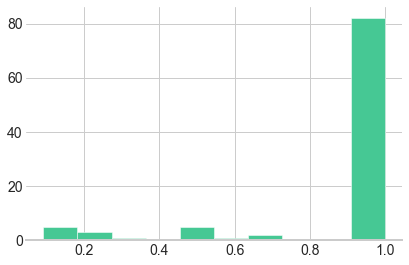

In [109]:

royalty_summary.loc[royalty_summary.full_royalty_sales >= 1,'full_royalty_rate'].hist(color='#46c894')

In [26]:
sales.loc[sales.paidFullRoyalty,'royaltyFeeBps'].value_counts()

500.0    129
554.0      1
Name: royaltyFeeBps, dtype: int64

<AxesSubplot:>

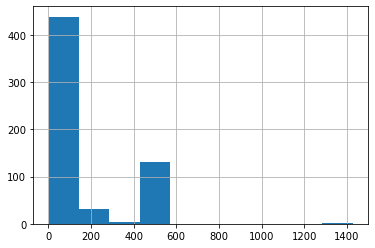

In [27]:
sales.royaltyFeeBps.hist()

In [32]:
sales.loc[sales.royaltyFeeBps>500.0,'missingRoyaltyTxHash'].iloc[1]

'0x09b109a433e0f4c77d0bc3a982e11e07a9270a00e23eec252898f6ec5d57833e'

In [86]:
sales[sales['from']=='0xE2Ebf46Ee25EAF54331bEF39b2Bf88B6d305B889'.lower()]

,id,saleId,token,orderId,orderSource,orderSide,orderKind,from,to,amount,...,royaltyFeeBps,paidFullRoyalty,feeBreakdown,isDeleted,createdAt,updatedAt,marketplaceFeeBps,block_time,fullRoyaltyTxHash,missingRoyaltyTxHash


In [ ]:
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c, 
0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c

In [34]:
sales[sales.txHash=='0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290884fd4005bcb9e45316c'.lower()]

,id,saleId,token,orderId,orderSource,orderSide,orderKind,from,to,amount,...,royaltyFeeBps,paidFullRoyalty,feeBreakdown,isDeleted,createdAt,updatedAt,marketplaceFeeBps,block_time,fullRoyaltyTxHash,missingRoyaltyTxHash
284,09900853dc4608f953a9a5a876cbbd1fee8fe2d54e0ebe...,41084105c30dd86bd81f159ba22edbd31246286c4101b4...,{'contract': '0x26badf693f2b103b021c670c852262...,0xf44ec86ba280cadf5e21b9226cce1af4ede674e12002...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
285,7b39944de811624e52175b9aeadf4b1b50345cf5c48dcc...,02c187ce25c1bc6358bbfc7f447035b362bee08c5f4ae8...,{'contract': '0x26badf693f2b103b021c670c852262...,0xf0a439b30ad45aa65723766be6c5ce72b214f73989fd...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
286,abd62df7aa572d5b9642ddbea44437cccaa0ca46b3cd9d...,a8bde8712a533f121118e3d44fd984a08857f7bd5641d1...,{'contract': '0x26badf693f2b103b021c670c852262...,0xe18ce32f30c026fecd6d48611162a98e3daa67bc540d...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
287,94f96b9989c2f0aea6f54ef308ffc9cfddfbf1d2a29f72...,1819f38da2ffa6c5725e64bb250e2a7ac7ff9025a5310a...,{'contract': '0x26badf693f2b103b021c670c852262...,0xdc205375ebed0e2fdd225eeda667bf28017853170947...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
288,10cde93fcc717ddc03504afa789f7264be5e7cb664c474...,bf07480b599c6dacd93374d00c5ce8d854641fcb1f5ed1...,{'contract': '0x26badf693f2b103b021c670c852262...,0xd8af9749a0c8d2cd2980281c49b8572ed88383c8258b...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
289,e14d2d6adf14ba9ed86ba4768f76423296cb5d3a49aea1...,8b9b5921823be41611c5ba6434ffca22242fd0e21efe7d...,{'contract': '0x26badf693f2b103b021c670c852262...,0xcbd189f61d00f4d7c30a60c7db87cabe34eabf400823...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
290,6c6479a23492b6a182b9049783b39cbfef2b19025bef9f...,eac1524741d8dc0913da8ee49c9cd1904cadde2f188c34...,{'contract': '0x26badf693f2b103b021c670c852262...,0xca169dff0224a6f0905a9f5fbe9878750f4a07e0ffcc...,blur.io,bid,blur,0xbdaefe578294842fb433769c6b0d95130099e96e,0xb7118e23c6bfa9efec528b31124468d29eaf9aeb,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-03-25T05:46:41.337Z,2023-03-25T05:47:53.763Z,NaN,2023-03-25 05:46:35,0x40ef1b08223a2e7c2ac8d655b00cdfa21c1f69f49290...,
291,8b96eb2a20777532b7166f06cc61fdd0854eae87371458...,f0f4e507c846e727e066fd98e589bf7fbc3c4626f83489...,{'contract': '0x26badf693f2b103b021c670c852262...,0xbcca71a3dce285a8654fe49f83077475394e06130532...,blur.io,bid,blur,0xbdaefe57829

In [36]:
sales.columns

Index(['id', 'saleId', 'token', 'orderId', 'orderSource', 'orderSide',
       'orderKind', 'from', 'to', 'amount', 'fillSource', 'block', 'txHash',
       'logIndex', 'batchIndex', 'timestamp', 'price', 'washTradingScore',
       'royaltyFeeBps', 'paidFullRoyalty', 'feeBreakdown', 'isDeleted',
       'createdAt', 'updatedAt', 'marketplaceFeeBps', 'block_time',
       'fullRoyaltyTxHash', 'missingRoyaltyTxHash'],
      dtype='object')

In [59]:
sales['from'].nunique()

326

In [39]:
sales.token[9]

{'contract': '0x26badf693f2b103b021c670c852262b379bbbe8a',
 'tokenId': '3971',
 'name': None,
 'image': None,
 'collection': {'id': None, 'name': None}}

In [72]:
output.sort_values(['Percent of Sales for Full Royalties',
                    'Full Royalty Sales'],ascending=False )#.to_csv('')

,Wallet,Percent of Sales for Full Royalties,Full Royalty Sales,Non-Full Royalty Sales,Total Sales,Illuminati Tokens Held on Snapshot Date,Tx Hashes for Full Royalties,Tx Hashes for Non-Full Royalties
251,0x78589dad2a38a92b6913c5e817c7e47104da6351,1.0,14,0,14,0.0,0x5d2a54a32d6678c7470d554f026a223acc1a7f17a65e...,
378,0xb7ffa8403e08e84db4305c169818917cf8791d8d,1.0,14,0,14,0.0,0xbc469b0c9057e6838d02ca8703316895a14c0e1a5559...,
46,0x1502589518ef7030ff2335bca82c4e48bcbdbd14,1.0,6,0,6,0.0,0x8319dbb6889004fdd9db3cab67240611837e93b31d15...,
279,0x89135f8ffa1e107799caef5328c6d3ae6e7d849c,1.0,6,0,6,6.0,0x5fc93d561353baab2a5a5a666f669fa45a756b9474d6...,
375,0xb6940b05101cf385053c7dfe626e23c1f8e6e2a2,1.0,6,0,6,0.0,0xbd35471f6a45907e3b1c0ceef8807d830680d989b511...,
...,...,...,...,...,...,...,...,...
371,0xb597b202294dd5a4a616fcc2f178588bfc6d2c16,0.0,0,1,1,0.0,,0xedb125714ad2ad3a16030bdcb57623dd0577f73998c1...
372,0xb5c3814ac0bc5177a22593e3b3d196dfe8954855,0.0,0,1,1,0.0,,0xbd79e0a23e8f496e60f8fdeb0bc99cde733c7f582138...
394,0xbde93ab6fcd81158bf3e1da50d6d3ebcd4c31d21,0.0,0,1,1,0.0,,0xb2916dbeb91fec75338b7af3cc6a873d78360cba4b09...
416,0xc6cf5a020bcfc65c6f8181c04cbb5ef5050fe28e,0.0,0,1,1,0.0,,0xec386870daa9a124309f995c68c36d8f631cb379f3ba...


In [77]:
output['Illuminati Tokens Held on Snapshot Date'].value_counts()

0.0     460
1.0      31
2.0      11
3.0       2
5.0       2
6.0       2
10.0      1
50.0      1
7.0       1
11.0      1
18.0      1
4.0       1
Name: Illuminati Tokens Held on Snapshot Date, dtype: int64

In [23]:
final = holders.merge(
    summary,
    how='left',
    on='address'
)

final[final['tokens']>3].to_csv('delme24.csv')

In [24]:
final[final['non_full_royalty_sales']>0]

,address,tokens,sales,full_royalty_sales,percent_royalty_sales,non_full_royalty_sales,fullRoyaltyTxHash,missingRoyaltyTxHash
9,0x774dd298809867f9e03cd2ae036a5c769d1c74e4,10.0,4.0,3.0,0.75,1.0,0x8a9c860f8212879d08a638c318109dd947ec619ca836...,0x0fcee05e4663fc8ccd005b910805eb2976b0a2274b4d...
33,0x02608803a2c3625bb388e9bd9fcf6ca0ce04c8c9,4.0,4.0,2.0,0.50,2.0,0xfc6c901510b37999dd6c62bc711ae539728f13bd9cea...,0x1b46f4fafa7256dad8ac6b155990a470abeb5aa18cee...
65,0xbf30facbf4fce1e3dbb14d48095e87fed5ea4c68,3.0,2.0,1.0,0.50,1.0,0xba30c2a7b5923ebae23155d295dd5a21543b48fc9a6a...,0xe200f7768994256cbb3af74bb92c546d51f1a8c26a76...
88,0x214850f38ad612972f1ccda613b59294dc60f2a6,2.0,2.0,1.0,0.50,1.0,0x27b6018f8f628c02067f0b471ccc967115b994e99074...,0x7ddd405de1a354ed413a769aea85d9e567bf42ef8651...
100,0x563df37683ff2513cceac514164285c89c4e2178,2.0,4.0,3.0,0.75,1.0,0x12e5abec9c451e66d2b9cb6ae09971857c9ec353bcac...,0x2765080f5b78675acd911d5c6732f7c5235994221e68...
347,0x77424437e320fc70ab04d983e259ca6e6e205c86,1.0,1.0,0.0,0.00,1.0,,0xce5db44e7b3ed275cb04fe829af96364ac92758a24aa...
349,0x77d67811527acdf2fc5c9748cfba0ee9013c2891,1.0,8.0,4.0,0.50,4.0,0x5091caec07d955420beaa007ae021b706cca7ecc5dda...,0x28d2409ce9250a02448d78d31eefb6731c12eebba3c4...


# Analysis

In [25]:
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline


In [8]:
sales.paidFullRoyalty = sales.paidFullRoyalty.fillna(False)

sales.groupby(sales.block_time.dt.date)['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
block_time,,,
2023-02-18,0.090909,2,22
2023-02-19,0.111111,1,9
2023-02-20,0.222222,2,9
2023-02-21,0.200000,2,10
2023-02-22,0.333333,2,6
2023-02-23,0.571429,4,7
2023-02-24,0.181818,2,11
2023-02-25,0.363636,4,11
2023-02-26,0.125000,3,24


In [9]:
sales.groupby('orderSource')['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
orderSource,,,
blur.io,0.102190,28,274
gem.xyz,0.357143,5,14
looksrare.org,0.000000,0,3
opensea.io,0.289552,97,335
x2y2.io,0.666667,2,3


In [10]:
sales.groupby('fillSource')['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
fillSource,,,
blur.io,0.100629,32,318
gem.xyz,0.125000,2,16
looksrare.org,0.000000,0,2
opensea.io,0.333333,97,291
x2y2.io,0.500000,1,2


In [11]:
sales.head()

,id,saleId,token,orderId,orderSource,orderSide,orderKind,from,to,amount,...,royaltyFeeBps,paidFullRoyalty,feeBreakdown,isDeleted,createdAt,updatedAt,marketplaceFeeBps,block_time,fullRoyaltyTxHash,missingRoyaltyTxHash
0,299c30a35eb9c1f4e6388bf9828d27d31861929ac33f7e...,09fdf3591cd7af8eb33972fa9d4237238c199399a3e3c0...,{'contract': '0x26badf693f2b103b021c670c852262...,0x1b8aa15ba9b05d8071c92e191c35e48fee7c0e4e43a6...,gem.xyz,bid,seaport-v1.4,0x2acf5053b707a4fc7d568f98fe8161aaa4e74cc3,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:53:03.388Z,2023-04-16T14:54:21.392Z,NaN,2023-04-16 14:52:47,0xc5963e1d6fd418c20afd971ae83fed09af6467ed218b...,
1,91dd14bf5beef3a6489f1b5a2e40cc26430e09ba6c9b08...,ad6fed82413400a667a10cc655b4a46b3a88a4762e1063...,{'contract': '0x26badf693f2b103b021c670c852262...,0xe538c16e143ebb2d11ba2b2b2e0739ec501821da5acd...,gem.xyz,bid,seaport-v1.4,0x15fca867b0521995dba0525cb3ec8e281b9a5807,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:10:28.645Z,2023-04-16T14:11:29.852Z,NaN,2023-04-16 14:10:23,0x0d455060b1353008d32ba59279c53baf37442bd4bb8e...,
2,07c00b4d54b587a26b60123c375ff072d1691210d022ae...,ca9d7a8816e16caee511491e1c1055942dda2ced1da495...,{'contract': '0x26badf693f2b103b021c670c852262...,0x6519474fca850f5bbb3c83f80bba186de0ea8beac76c...,looksrare.org,bid,looks-rare-v2,0xb055da94fd9ae45fe518da738d5c8da92ab1138f,0xedbe6ed3426e6c12bf1d1cd4ba06cc620d0800f1,1,...,50.0,False,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-16T13:31:51.479Z,2023-04-16T13:33:05.107Z,NaN,2023-04-16 13:31:47,,0xee54977513922508c5f0042216cab9e070a3fd57ec22...
3,3234b3821b2b408891a88bd0d7e3110559cac80159b496...,3ecf8eb299bde9097a1aa516aaf8023bbb302f6aeca4d1...,{'contract': '0x26badf693f2b103b021c670c852262...,0xd100fa8d62cd497a8c0904477a7cd3c44072035e8230...,blur.io,bid,blur,0x58454e733bf7d5999607c0e777a9a4df00d60d82,0x1c8f86d7647a9510fc715612c440a6c010c25b82,1,...,50.0,False,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T14:05:48.646Z,2023-04-13T14:06:43.769Z,NaN,2023-04-13 14:05:35,,0xb3313ee26b352077d668616a0aa3066b5d77ae3fc4f3...
4,ba0742d5610d250675531f961cb60c0dcecc873b143fac...,1638de1b5eb631d5f00069f086a801992215bff7eb9604...,{'contract': '0x26badf693f2b103b021c670c852262...,0x06b9f04f1b0a851095c151ece9e48bb211476802482c...,opensea.io,ask,seaport-v1.4,0xeaeaa1e30d62bea880d5f38171bb32a2f91bfdce,0x53ed9466627eae9abe3b4cb1bcbc309cbe0e967b,1,...,50.0,False,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T13:00:30.279Z,2023-04-13T13:01:28.920Z,NaN,2023-04-13 13:00:11,,0xffc1dcf121f15304afe33da55240a4c5263d33ae5e8f...


<AxesSubplot:>

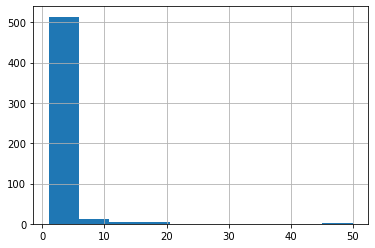

In [28]:
holders['tokens'].hist()

In [12]:
# sells = df.groupby('from')['paidFullRoyalty'].agg({'mean','count','sum'})

# sells.reset_index(inplace=True)

# columns = {
#     'from' : 'address',
#     'count' : 'sales',
#     'sum' : 'full_royalty_sales',
#     'mean' : 'percent_royalty_sales'
# }

# sells = sells.rename(columns=columns)

# sells['non_full_royalty_sales'] = sells['sales'] - sells['full_royalty_sales']


# df['fullRoyaltyTxHash'] = ""
# df['missingRoyaltyTxHash'] = ""
# df.loc[df.paidFullRoyalty, 'fullRoyaltyTxHash'] = df.loc[df.paidFullRoyalty, 'txHash']
# df.loc[~df.paidFullRoyalty, 'missingRoyaltyTxHash'] = df.loc[~df.paidFullRoyalty, 'txHash']


# sells = (df.groupby('from').agg(
#         full_royalty_rate = ('paidFullRoyalty',np.mean),
#         full_royalty_sales = ('paidFullRoyalty',np.sum),
#         total_sales = ('paidFullRoyalty',len),
#         full_royalty_txns=('fullRoyaltyTxHash', lambda x: ', '.join(filter(None, x))),
#         missing_royalty_txns=('missingRoyaltyTxHash', lambda x: ', '.join(filter(None, x)))
#     )
# )

# sells = sells.reset_index().rename(columns={'from':'address'})

# sells_tx = (df.groupby('from').agg({
#         'fullRoyaltyTxHash': lambda x: ', '.join(filter(None, x)),
#         'missingRoyaltyTxHash': lambda x: ', '.join(filter(None, x))
#     })
# )

# sells_tx.reset_index(inplace=True)
# columns = {
#     'from' : 'address'
# }

# sells_tx = sells_tx.rename(columns=columns)

# summary = sells.merge(
#     sells_tx,
#     how='left',
#     on='address'
# )

In [58]:
# def filter_sales_to_after_opensea_went_royalty_optional(df):
#     '''Removes sales that happened before OpenSea made royalties optional.
    
#     Returns dataframe with sales on Feb 18, 2023 and after since OpenSea changed policy on
#     Feb 17, 2023.
#     '''
#     df['block_time'] = pd.to_datetime(df.timestamp, unit='s')
    
#     first_sale_date = df.block_time.min()
#     last_sale_date = df.block_time.max()
#     n_sales = len(df)
#     print(f'Before filtering, there are {n_sales} sales.')
#     print(f'These sales took place from {first_sale_date} to {last_sale_date}.')
#     print('Removing sales before OpenSea made royalties optional on 2023-02-17.')
    
#     # Removes sales before OpenSea set royalties optional. 
#     df = df[df.block_time >= '2023-02-18']
#     n_sales = len(df)
#     print(f'After filtering there are {n_sales}')
    
#     return df